In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
# Load datasets
df_players = pd.read_csv('all_players_stats.csv')
df_stats = pd.read_csv('soccer21-22.csv')

/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/1068127938.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Player', y='ForwardScore', data=worst_4_forwards, palette='Blues_r', ax=ax1)
/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/1068127938.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_4_forwards['PenaltyPercentage'] = (worst_4_forwards['Penalties'] / worst_4_forwards['Goals']) * 100
/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/1068127938.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Top 4 Forwards Who Should Be Sold Based on Performance:
        Player                    Team  Apearances  Goals  Penalties  MinutesPerGoal  GoalContribution  GoalEfficiency  ForwardScore
   Fábio Silva Wolverhampton Wanderers          10      0          0             0.0          0.000000        0.000000    -36.000000
Adam Armstrong             Southampton          21      2          0           735.0          4.651163        0.084164    -29.097730
 Wout Weghorst                 Burnley          17      2          0           675.0          5.882353        0.131488    -21.120242
   Jordan Ayew          Crystal Palace          25      3          0           570.0          6.000000        0.091200     -8.276000


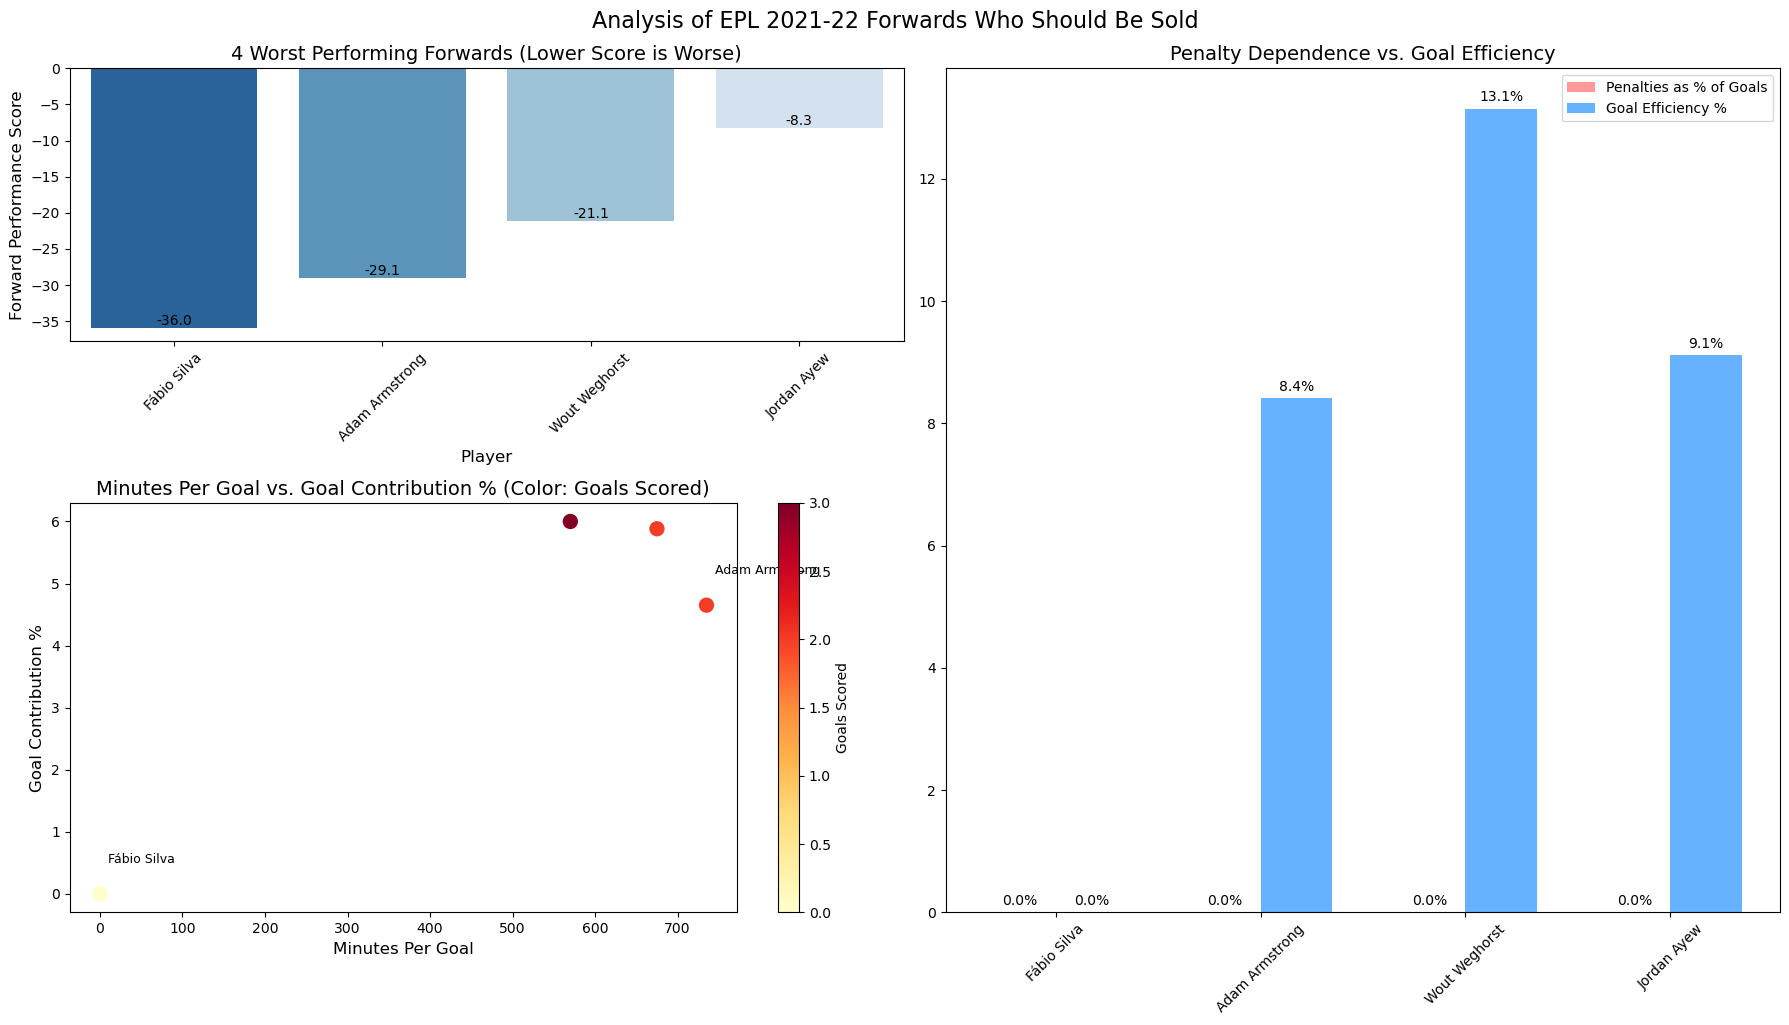

In [5]:
# 1. Filter for forwards only
forwards = df_players[df_players['Position'] == 'Forward'].copy()

# 2. Calculate additional performance metrics
# Calculate appearance percentage (out of 38 possible games)
forwards['AppearancePercentage'] = (forwards['Apearances'] / 38) * 100

# Calculate substitution rate
forwards['SubstitutionRate'] = (forwards['Substitutions'] / forwards['Apearances']) * 100
forwards['SubstitutionRate'] = forwards['SubstitutionRate'].fillna(0)  # Handle divide by zero

# Calculate minutes per goal (estimate using appearances and substitutions)
# Assume average appearance is 90 minutes and average sub appearance is 30 minutes
forwards['EstimatedMinutes'] = (forwards['Apearances'] - forwards['Substitutions']) * 90 + forwards['Substitutions'] * 30
forwards['MinutesPerGoal'] = forwards['EstimatedMinutes'] / forwards['Goals']
forwards['MinutesPerGoal'] = forwards['MinutesPerGoal'].replace([np.inf, -np.inf], 0)  # Handle divide by zero
forwards['MinutesPerGoal'] = forwards['MinutesPerGoal'].fillna(0)  # Handle NaN

# 3. Calculate team attack metrics (from match stats)
team_attack_metrics = {}

# Calculate attack metrics by team
for team in df_players['Team'].unique():
    # Home and away goals
    home_goals = df_stats[df_stats['HomeTeam'] == team]['FTHG'].sum()
    away_goals = df_stats[df_stats['AwayTeam'] == team]['FTAG'].sum()
    total_goals = home_goals + away_goals
    
    # Home and away shots
    home_shots = df_stats[df_stats['HomeTeam'] == team]['HS'].sum()
    away_shots = df_stats[df_stats['AwayTeam'] == team]['AS'].sum()
    total_shots = home_shots + away_shots
    
    # Home and away shots on target
    home_shots_on_target = df_stats[df_stats['HomeTeam'] == team]['HST'].sum()
    away_shots_on_target = df_stats[df_stats['AwayTeam'] == team]['AST'].sum()
    total_shots_on_target = home_shots_on_target + away_shots_on_target
    
    # Shot conversion rate (goals/shots on target)
    shot_conversion = total_goals / total_shots_on_target if total_shots_on_target > 0 else 0
    
    # Shooting accuracy (shots on target/total shots)
    shooting_accuracy = total_shots_on_target / total_shots if total_shots > 0 else 0
    
    # Average goals per game
    goals_per_game = total_goals / 38  # 38 games in a season
    
    team_attack_metrics[team] = {
        'TeamGoals': total_goals,
        'TeamShotConversion': shot_conversion * 100,  # as percentage
        'TeamShootingAccuracy': shooting_accuracy * 100,  # as percentage
        'TeamGoalsPerGame': goals_per_game
    }

# Create DataFrame for team attack metrics
team_attack_df = pd.DataFrame.from_dict(team_attack_metrics, orient='index').reset_index()
team_attack_df.columns = ['Team', 'TeamGoals', 'TeamShotConversion', 'TeamShootingAccuracy', 'TeamGoalsPerGame']

# 4. Merge team metrics with forwards data
forwards = forwards.merge(team_attack_df, on='Team')

# 5. Calculate forward contribution metrics
# Goal contribution as percentage of team goals
forwards['GoalContribution'] = (forwards['Goals'] / forwards['TeamGoals']) * 100
forwards['GoalContribution'] = forwards['GoalContribution'].fillna(0)  # Handle divide by zero

# Goal efficiency (compared to team average)
forwards['GoalEfficiency'] = forwards['Goals'] / (forwards['AppearancePercentage'] / 100 * forwards['TeamGoalsPerGame'] * 38)
forwards['GoalEfficiency'] = forwards['GoalEfficiency'].fillna(0)  # Handle NaN
forwards['GoalEfficiency'] = forwards['GoalEfficiency'].replace([np.inf, -np.inf], 0)  # Handle extreme values

# 6. Calculate forward quality score (lower is worse for forwards too)
forwards['ForwardScore'] = (
    forwards['Goals'] * 10 + 
    forwards['GoalContribution'] * 2 + 
    (forwards['GoalEfficiency'] - 1) * 20 - 
    forwards['MinutesPerGoal'] * 0.05 - 
    forwards['SubstitutionRate'] * 0.1 - 
    forwards['Penalties'] / forwards['Goals'].clip(lower=1) * 10  # Using clip instead of conditional
)

# 7. Identify the worst forwards (bottom by ForwardScore with at least 10 appearances)
regular_forwards = forwards[forwards['Apearances'] >= 10].copy()
worst_forwards = regular_forwards.sort_values('ForwardScore').head(20)

# 8. Select the 4 worst forwards for detailed analysis
worst_4_forwards = worst_forwards.head(4)

# 9. Create visualizations
plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[1, 1.5])

# Plot 1: Bar chart of the 4 worst forwards with their scores
ax1 = plt.subplot(gs[0, 0])
sns.barplot(x='Player', y='ForwardScore', data=worst_4_forwards, palette='Blues_r', ax=ax1)
ax1.set_title('4 Worst Performing Forwards (Lower Score is Worse)', fontsize=14)
ax1.set_xlabel('Player', fontsize=12)
ax1.set_ylabel('Forward Performance Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

for i, p in enumerate(ax1.patches):
    ax1.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=10)

# Plot 2: Scatter plot of Minutes Per Goal vs. Goal Contribution
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(
    x='MinutesPerGoal',
    y='GoalContribution',
    s=100,
    c=worst_4_forwards['Goals'],
    cmap='YlOrRd',
    data=worst_4_forwards
)
ax3.set_title('Minutes Per Goal vs. Goal Contribution % (Color: Goals Scored)', fontsize=14)
ax3.set_xlabel('Minutes Per Goal', fontsize=12)
ax3.set_ylabel('Goal Contribution %', fontsize=12)

for i, row in worst_4_forwards.iterrows():
    ax3.annotate(row['Player'], 
                (row['MinutesPerGoal'] + 10, row['GoalContribution'] + 0.5),
                fontsize=9)

plt.colorbar(scatter, label='Goals Scored')

# Plot 3: Bar chart showing penalty dependence and efficiency
ax4 = plt.subplot(gs[:, 1])
x = np.arange(len(worst_4_forwards))
width = 0.35

# Calculate penalty percentage and non-penalty goals
worst_4_forwards['PenaltyPercentage'] = (worst_4_forwards['Penalties'] / worst_4_forwards['Goals']) * 100
worst_4_forwards['PenaltyPercentage'] = worst_4_forwards['PenaltyPercentage'].fillna(0)  # Handle divide by zero
worst_4_forwards['PenaltyPercentage'] = worst_4_forwards['PenaltyPercentage'].replace([np.inf, -np.inf], 0)  # Handle extreme values

bars1 = ax4.bar(x - width/2, worst_4_forwards['PenaltyPercentage'], width, label='Penalties as % of Goals', color='#FF9999')
bars2 = ax4.bar(x + width/2, worst_4_forwards['GoalEfficiency'] * 100, width, label='Goal Efficiency %', color='#66B2FF')

ax4.set_title('Penalty Dependence vs. Goal Efficiency', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(worst_4_forwards['Player'], rotation=45)
ax4.legend()

# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    ax4.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax4.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Overall title and layout adjustments
plt.tight_layout()
plt.suptitle('Analysis of EPL 2021-22 Forwards Who Should Be Sold', fontsize=16, y=1.02)

# 10. Print detailed stats for the worst forwards
print("Top 4 Forwards Who Should Be Sold Based on Performance:")
detail_cols = ['Player', 'Team', 'Apearances', 'Goals', 'Penalties', 'MinutesPerGoal', 
               'GoalContribution', 'GoalEfficiency', 'ForwardScore']
print(worst_4_forwards[detail_cols].to_string(index=False))

plt.savefig('worst_forwards_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/2471335427.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Player', y='DefenderScore', data=worst_4_defenders, palette='Reds_r', ax=ax1)


Top 4 Defenders Who Should Be Sold Based on Performance:
       Player        Team  Apearances  Substitutions  SubstitutionRate  YellowCards  RedCards  DisciplinaryIssues  GoalsConceded  ShotConversionAgainst  DefenderScore
       Lyanco Southampton          12              6         50.000000          3.0       0.0                 3.0             67              35.449735     -37.651184
Jeremy Ngakia     Watford          12              7         58.333333          0.0       0.0                 0.0             77              39.896373     -37.541169
    Joe Gomez   Liverpool          11             10         90.909091          3.0       0.0                 3.0             26              23.636364     -32.515789
  Rob Holding     Arsenal          14              7         50.000000          3.0       1.0                 6.0             48              32.653061     -31.873899


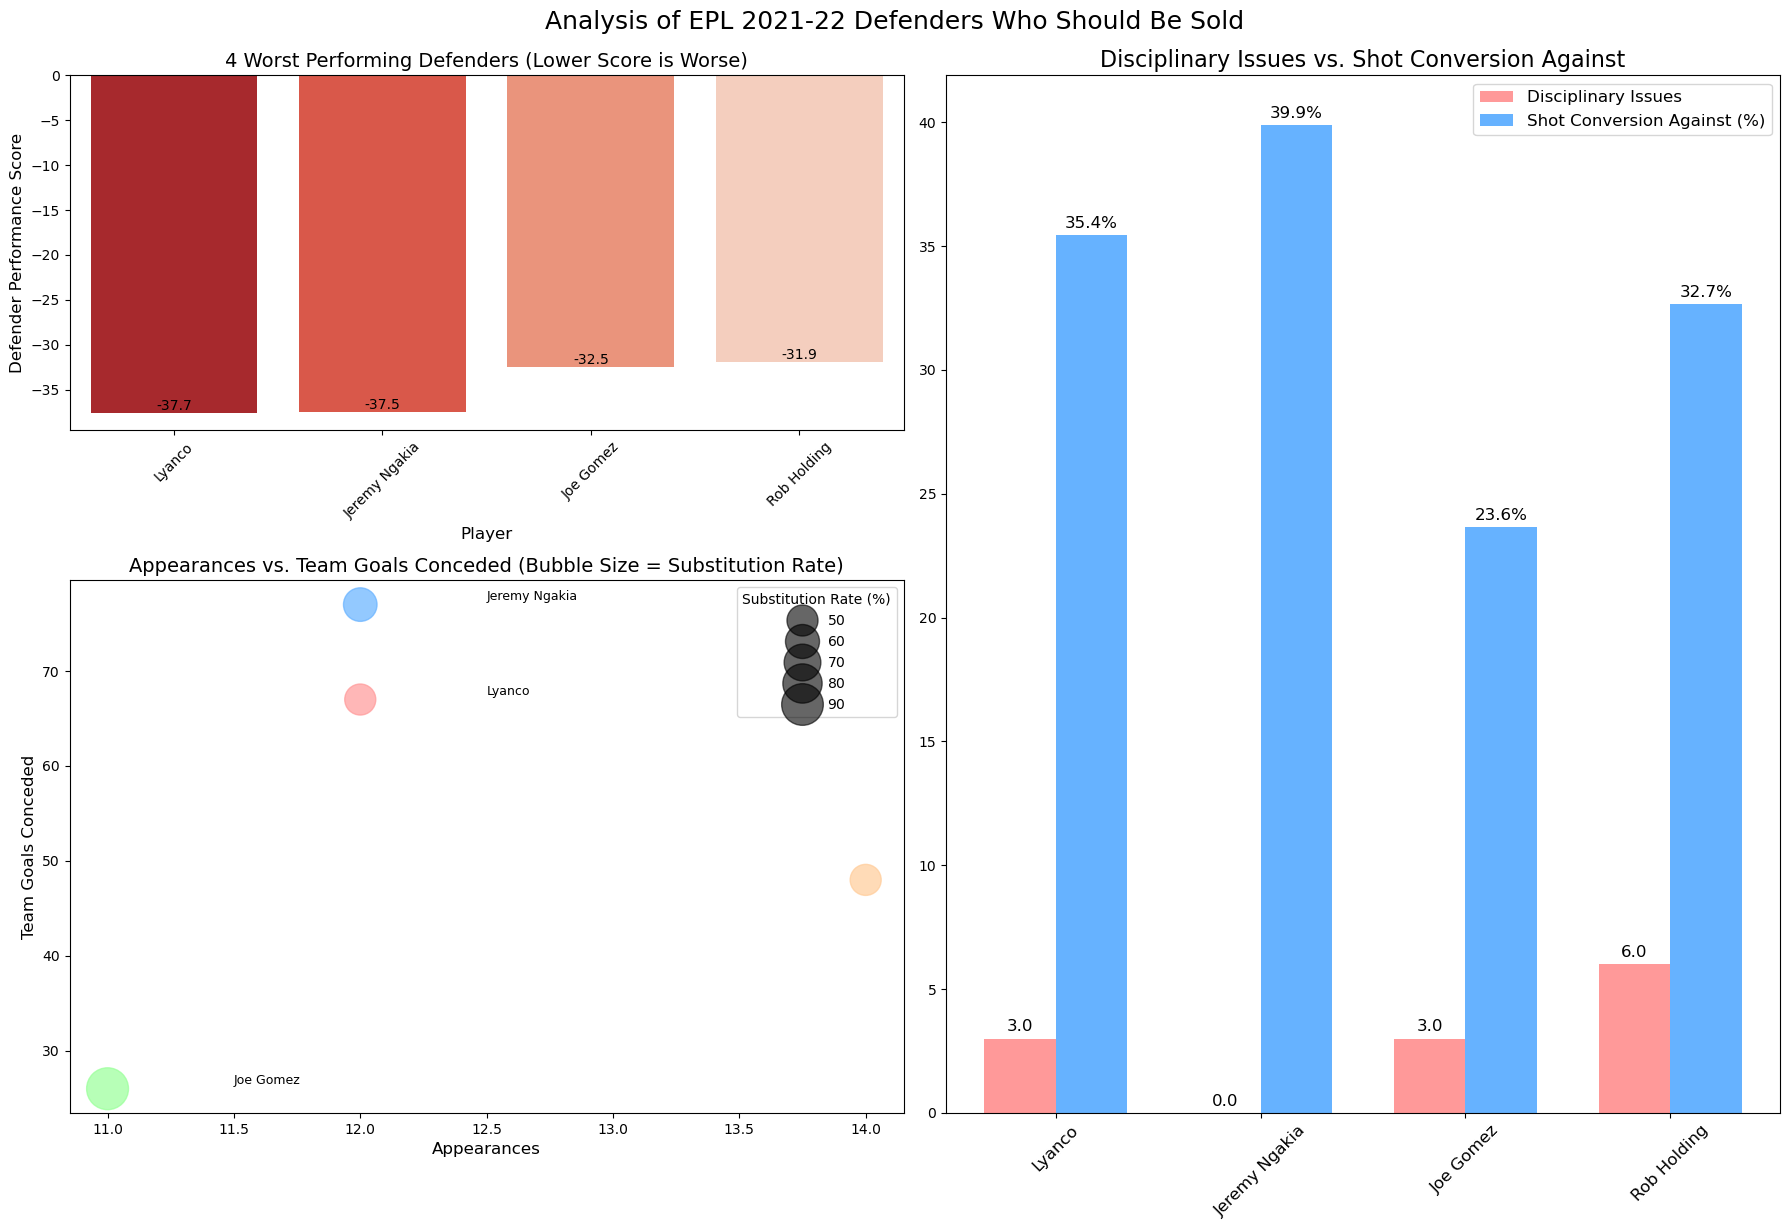

In [6]:
# Filter for defenders only
defenders = df_players[df_players['Position'] == 'Defender'].copy()
defenders['AppearancePercentage'] = (defenders['Apearances'] / 38) * 100
defenders['SubstitutionRate'] = (defenders['Substitutions'] / defenders['Apearances']) * 100
defenders['SubstitutionRate'] = defenders['SubstitutionRate'].fillna(0)
defenders['DisciplinaryIssues'] = defenders['YellowCards'] + (3 * defenders['RedCards'])

# Calculate team goals conceded
team_goals_conceded = {}
for team in df_players['Team'].unique():
    home_conceded = df_stats[df_stats['HomeTeam'] == team]['FTAG'].sum()
    away_conceded = df_stats[df_stats['AwayTeam'] == team]['FTHG'].sum()
    team_goals_conceded[team] = home_conceded + away_conceded

goals_conceded_df = pd.DataFrame(list(team_goals_conceded.items()), columns=['Team', 'GoalsConceded'])

# Calculate additional defensive metrics
team_defensive_metrics = {}
for team in df_players['Team'].unique():
    home_shots_faced = df_stats[df_stats['HomeTeam'] == team]['AS'].sum()
    away_shots_faced = df_stats[df_stats['AwayTeam'] == team]['HS'].sum()
    total_shots_faced = home_shots_faced + away_shots_faced
    
    home_shots_on_target_faced = df_stats[df_stats['HomeTeam'] == team]['AST'].sum()
    away_shots_on_target_faced = df_stats[df_stats['AwayTeam'] == team]['HST'].sum()
    total_shots_on_target_faced = home_shots_on_target_faced + away_shots_on_target_faced
    
    shot_conversion_against = team_goals_conceded[team] / total_shots_on_target_faced if total_shots_on_target_faced > 0 else 0
    
    team_defensive_metrics[team] = {
        'ShotsFaced': total_shots_faced,
        'ShotsOnTargetFaced': total_shots_on_target_faced,
        'ShotConversionAgainst': shot_conversion_against * 100
    }

defensive_metrics_df = pd.DataFrame.from_dict(team_defensive_metrics, orient='index').reset_index()
defensive_metrics_df.columns = ['Team', 'ShotsFaced', 'ShotsOnTargetFaced', 'ShotConversionAgainst']

defenders = defenders.merge(goals_conceded_df, on='Team')
defenders = defenders.merge(defensive_metrics_df, on='Team')

# Calculate defender quality score
defenders['DefenderScore'] = (
    defenders['AppearancePercentage'] * 0.3 +defenders['Goals'] * 5 - defenders['SubstitutionRate'] * 0.2 -
    defenders['DisciplinaryIssues'] * 2 - (defenders['GoalsConceded'] / 5) - defenders['ShotConversionAgainst'] * 0.5
)

regular_defenders = defenders[defenders['Apearances'] >= 10].copy()
worst_defenders = regular_defenders.sort_values('DefenderScore').head(20)
worst_4_defenders = worst_defenders.head(4)

# Create visualizations
plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[1, 1.5])  # Adjusted height_ratios

# Plot 1: Bar chart of the 4 worst defenders with their scores
ax1 = plt.subplot(gs[0, 0])
sns.barplot(x='Player', y='DefenderScore', data=worst_4_defenders, palette='Reds_r', ax=ax1)
ax1.set_title('4 Worst Performing Defenders (Lower Score is Worse)', fontsize=14)
ax1.set_xlabel('Player', fontsize=12)
ax1.set_ylabel('Defender Performance Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Plot 2: Bubble plot for Appearances vs. Goals Conceded
ax2 = plt.subplot(gs[1, 0])
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
scatter = ax2.scatter(
    x='Apearances',
    y='GoalsConceded',
    s=worst_4_defenders['SubstitutionRate'] * 10,
    c=[colors[i] for i in range(len(worst_4_defenders))],
    alpha=0.7,
    data=worst_4_defenders
)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda s: s/10)
legend = ax2.legend(handles, labels, loc="upper right", title="Substitution Rate (%)")

ax2.set_title('Appearances vs. Team Goals Conceded (Bubble Size = Substitution Rate)', fontsize=14)
ax2.set_xlabel('Appearances', fontsize=12)
ax2.set_ylabel('Team Goals Conceded', fontsize=12)

for i, row in worst_4_defenders.iterrows():
    ax2.annotate(row['Player'], 
                (row['Apearances'] + 0.5, row['GoalsConceded'] + 0.5),
                fontsize=9)

# Plot 3: Enlarged Bar Chart of Disciplinary Issues vs. Shot Conversion Against
ax3 = plt.subplot(gs[:, 1])  # Take the full right column
x = np.arange(len(worst_4_defenders))
width = 0.35

bars1 = ax3.bar(x - width/2, worst_4_defenders['DisciplinaryIssues'], width, label='Disciplinary Issues', color='#FF9999')
bars2 = ax3.bar(x + width/2, worst_4_defenders['ShotConversionAgainst'], width, label='Shot Conversion Against (%)', color='#66B2FF')

ax3.set_title('Disciplinary Issues vs. Shot Conversion Against', fontsize=16)
ax3.set_xticks(x)
ax3.set_xticklabels(worst_4_defenders['Player'], rotation=45, fontsize=12)
ax3.legend(fontsize=12)

for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Overall title and layout adjustments
plt.tight_layout()
plt.suptitle('Analysis of EPL 2021-22 Defenders Who Should Be Sold', fontsize=18, y=1.02)

# Display data table for worst defenders
print("Top 4 Defenders Who Should Be Sold Based on Performance:")
detail_cols = ['Player', 'Team', 'Apearances', 'Substitutions', 'SubstitutionRate', 
               'YellowCards', 'RedCards', 'DisciplinaryIssues', 'GoalsConceded', 
               'ShotConversionAgainst', 'DefenderScore']
print(worst_4_defenders[detail_cols].to_string(index=False))

plt.savefig('worst_defenders_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/2249564550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midfielders['MinutesPlayed'] = (midfielders['Apearances'] - midfielders['Substitutions']) * 90
/var/folders/kw/fydpgvv13pndyxfn35fdpfpw0000gn/T/ipykernel_36307/2249564550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midfielders['GoalsPerGame'] = midfielders['Goals'] / midfielders['Apearances'].clip(lower=1)


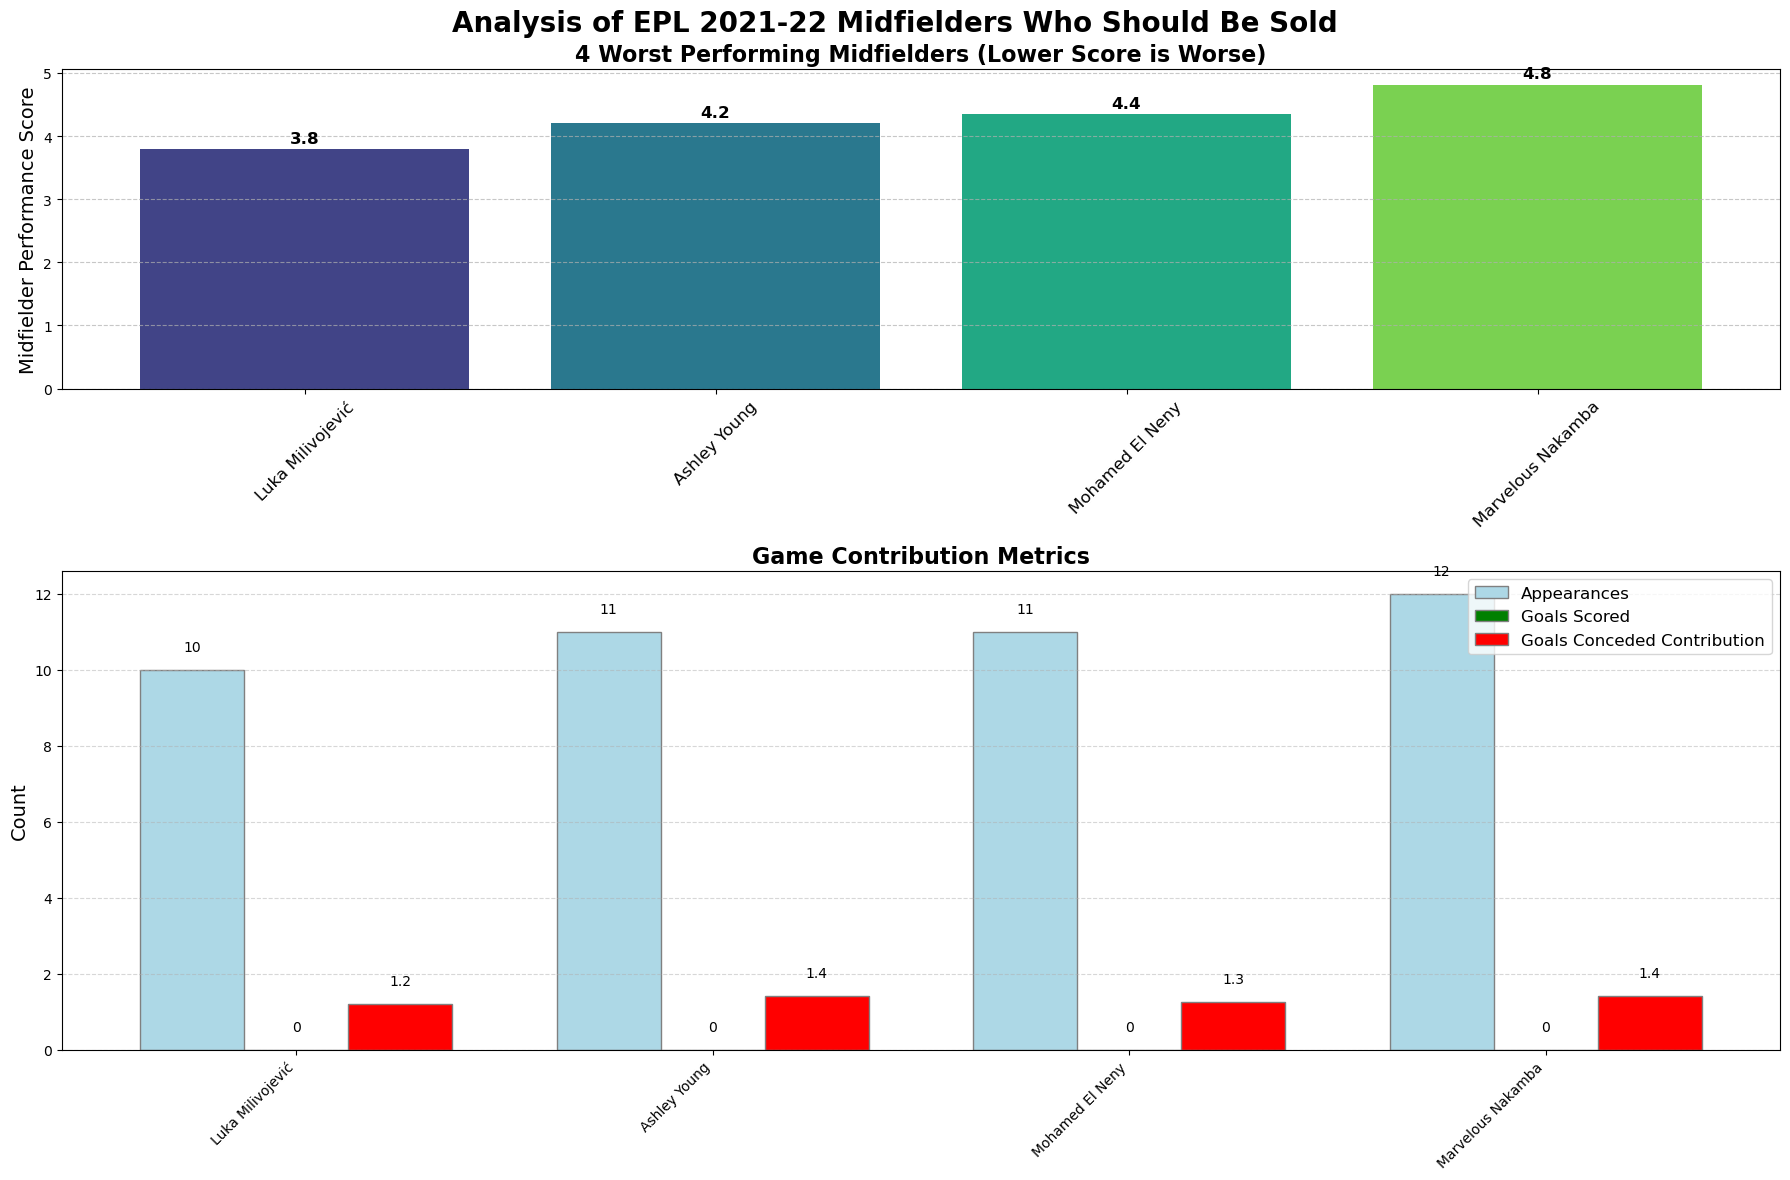

Streamlined analysis of the 4 worst-performing midfielders complete!


In [7]:
# Filter midfielders
midfielders = df_players[df_players['Position'].str.contains('Midfielder', case=False, na=False)]

# Calculate additional metrics for midfielders
midfielders['MinutesPlayed'] = (midfielders['Apearances'] - midfielders['Substitutions']) * 90
midfielders['GoalsPerGame'] = midfielders['Goals'] / midfielders['Apearances'].clip(lower=1)

# Calculate team defensive metrics (goals conceded per game)
team_defense = {}
for team in df_stats['HomeTeam'].unique():
    home_games = df_stats[df_stats['HomeTeam'] == team]
    away_games = df_stats[df_stats['AwayTeam'] == team]
    
    goals_conceded = home_games['FTAG'].sum() + away_games['FTHG'].sum()
    total_games = len(home_games) + len(away_games)
    
    team_defense[team] = goals_conceded / total_games if total_games > 0 else 0

# Convert to DataFrame and merge with midfielders
defense_df = pd.DataFrame(list(team_defense.items()), columns=['Team', 'TeamGoalsConceded'])
midfielders = midfielders.merge(defense_df, on='Team', how='left')

# Normalize team goals conceded to per-player basis
midfielders['PlayerDefensiveContribution'] = midfielders['TeamGoalsConceded'] / midfielders['Apearances'].clip(lower=1)

# Calculate Midfielder Score (lower is worse)
midfielders['MidfielderScore'] = (
    midfielders['Goals'] * 5 - midfielders['PlayerDefensiveContribution'] * 10 + midfielders['Apearances'] * 0.5
)

# Filter for analysis (players with at least 10 appearances)
qualified_midfielders = midfielders[midfielders['Apearances'] >= 10].copy()

# Get the 4 worst midfielders
worst_midfielders = qualified_midfielders.sort_values('MidfielderScore').head(4)

# Create visualization with GridSpec layout
plt.figure(figsize=(18, 12))
gs = GridSpec(2, 1, figure=plt.gcf(), height_ratios=[1, 1.5])

# Plot 1: Main Performance Score Chart
ax1 = plt.subplot(gs[0, 0])
bars = ax1.bar(
    worst_midfielders['Player'],
    worst_midfielders['MidfielderScore'],
    color=sns.color_palette("viridis", 4)
)

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + (0.1 if height > 0 else -5),
        f'{height:.1f}',
        ha='center',
        color='black' if height > 0 else 'white',
        fontweight='bold',
        size=12
    )

ax1.set_title('4 Worst Performing Midfielders (Lower Score is Worse)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Midfielder Performance Score', fontsize=14)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Game Contribution Chart
ax2 = plt.subplot(gs[1, 0])

# Set width of bars
barWidth = 0.25
 
# Set positions of the bars on X axis
r1 = np.arange(len(worst_midfielders))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Create the bars
ax2.bar(r1, worst_midfielders['Apearances'], width=barWidth, edgecolor='grey', label='Appearances', color='lightblue')
ax2.bar(r2, worst_midfielders['Goals'], width=barWidth, edgecolor='grey', label='Goals Scored', color='green')
ax2.bar(r3, worst_midfielders['Apearances'] * worst_midfielders['PlayerDefensiveContribution'], width=barWidth, 
       edgecolor='grey', label='Goals Conceded Contribution', color='red')

# Add values on top of the bars
for i, value in enumerate(worst_midfielders['Apearances']):
    ax2.text(r1[i], value + 0.5, f'{value:.0f}', ha='center', fontsize=10)
    
for i, value in enumerate(worst_midfielders['Goals']):
    ax2.text(r2[i], value + 0.5, f'{value:.0f}', ha='center', fontsize=10)
    
conceded = worst_midfielders['Apearances'] * worst_midfielders['PlayerDefensiveContribution']
for i, value in enumerate(conceded):
    ax2.text(r3[i], value + 0.5, f'{value:.1f}', ha='center', fontsize=10)

# Add x tick labels
plt.xticks([r + barWidth for r in range(len(worst_midfielders))], worst_midfielders['Player'], rotation=45, ha='right')

# Create legend & labels
ax2.set_ylabel('Count', fontsize=14)
ax2.set_title('Game Contribution Metrics', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Add a second y-axis for the ratio

goal_conceded_ratio = worst_midfielders['Goals'] / (worst_midfielders['Apearances'] * worst_midfielders['PlayerDefensiveContribution']).clip(lower=0.1)
ax3.plot([r + barWidth for r in range(len(worst_midfielders))], goal_conceded_ratio, 'o-', color='purple', linewidth=2, markersize=8)
ax3.set_ylabel('Goals to Conceded Ratio', color='purple', fontsize=14)
ax3.tick_params(axis='y', labelcolor='purple')

# Add ratio values on the line
for i, value in enumerate(goal_conceded_ratio):
    ax3.text(r2[i], value + 0.05, f'{value:.2f}', ha='center', va='bottom', color='purple', fontsize=10)

plt.suptitle('Analysis of EPL 2021-22 Midfielders Who Should Be Sold', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('worst_midfielders_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("Streamlined analysis of the 4 worst-performing midfielders complete!")